<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   acc_x        9005 non-null   float64
 1   acc_y        8998 non-null   float64
 2   acc_z        8999 non-null   float64
 3   gyr_x        8984 non-null   float64
 4   gyr_y        8938 non-null   float64
 5   gyr_z        8945 non-null   float64
 6   participant  9009 non-null   object 
 7   label        9009 non-null   object 
 8   category     9009 non-null   object 
 9   set          9009 non-null   int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 774.2+ KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   acc_x        9009 non-null   

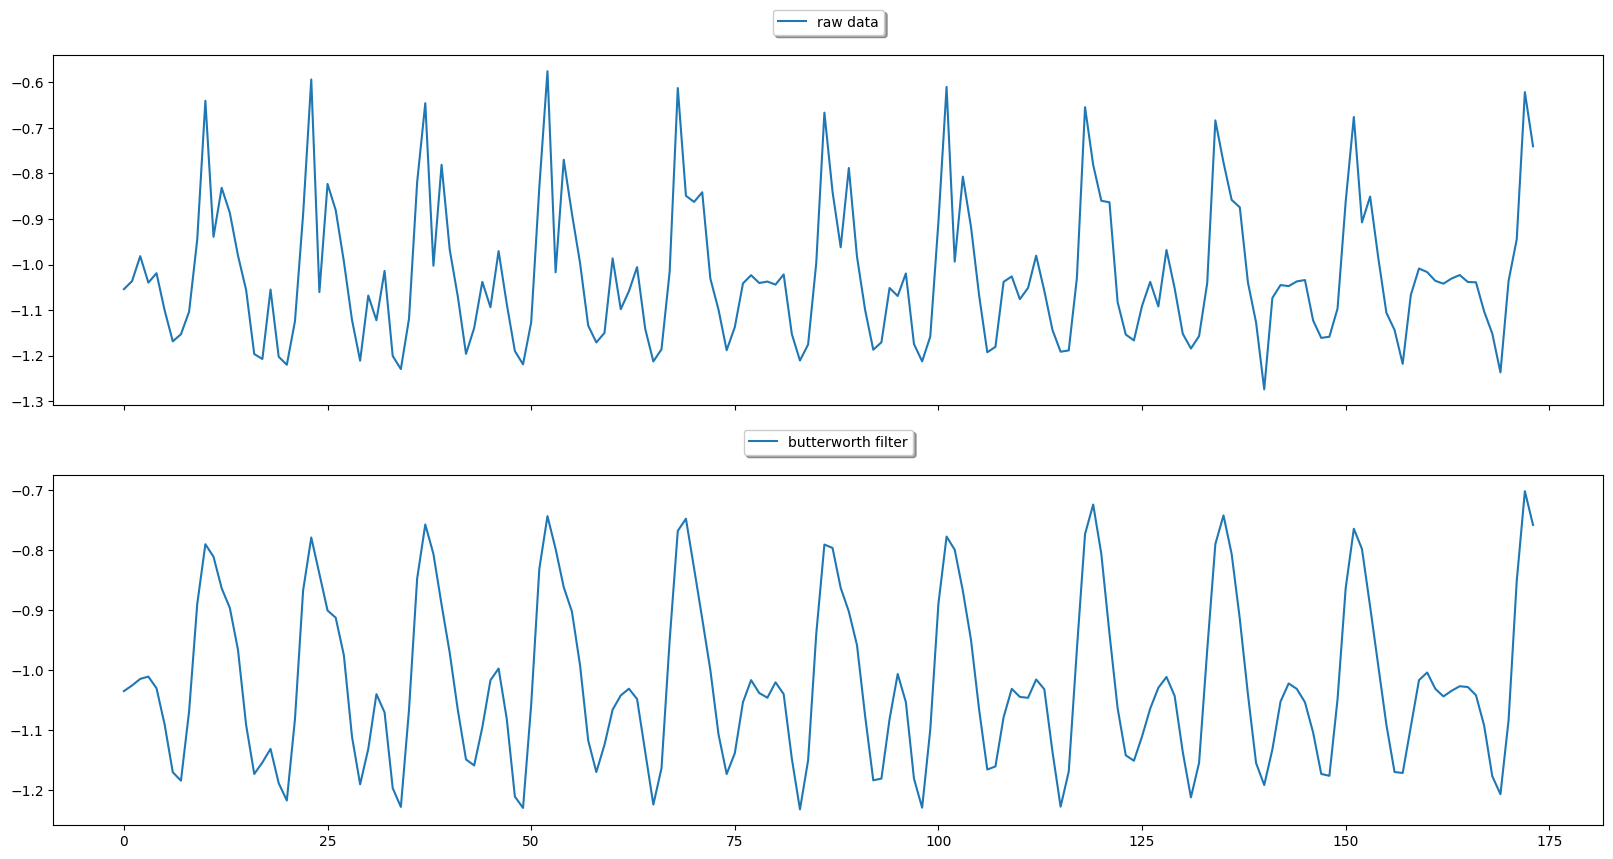

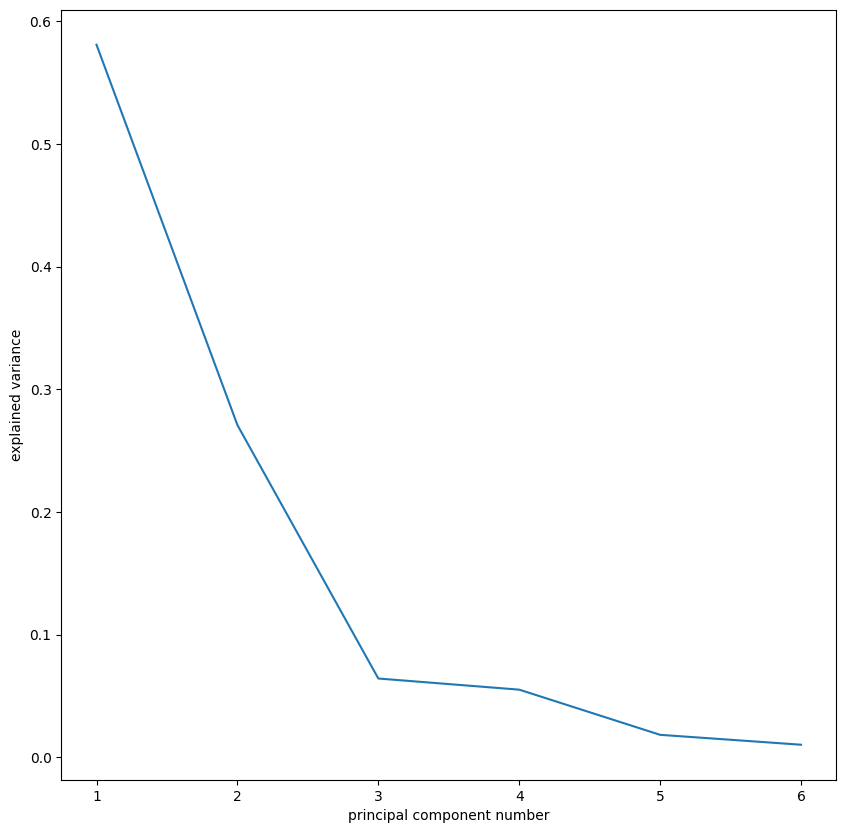

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9009 entries, 0 to 9008
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   epoch (ms)                 9009 non-null   datetime64[ns]
 1   acc_x                      9009 non-null   float64       
 2   acc_y                      9009 non-null   float64       
 3   acc_z                      9009 non-null   float64       
 4   gyr_x                      9009 non-null   float64       
 5   gyr_y                      9009 non-null   float64       
 6   gyr_z                      9009 non-null   float64       
 7   participant                9009 non-null   object        
 8   label                      9009 non-null   object        
 9   category                   9009 non-null   object        
 10  set                        9009 non-null   int64         
 11  duration                   9009 non-null   float64       
 12  pca_1 

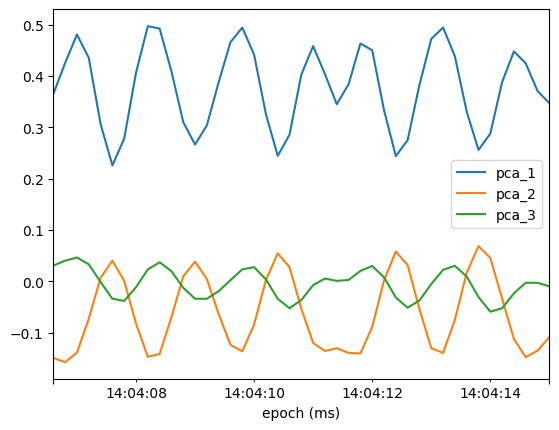

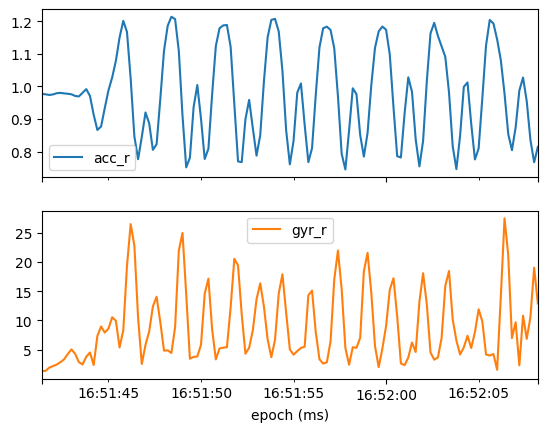

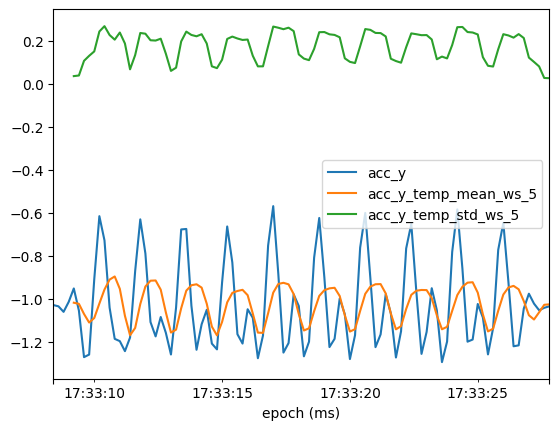

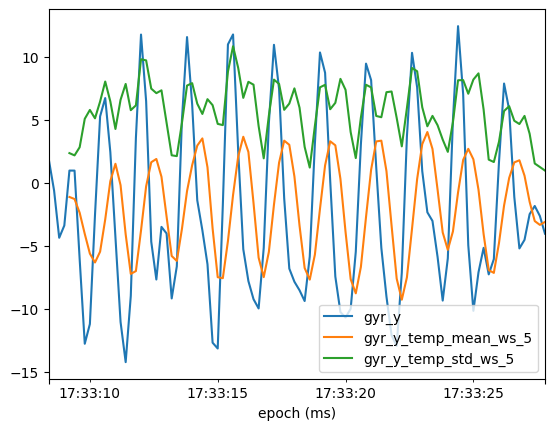

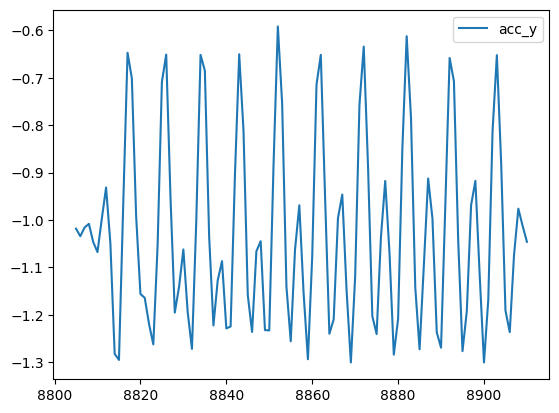

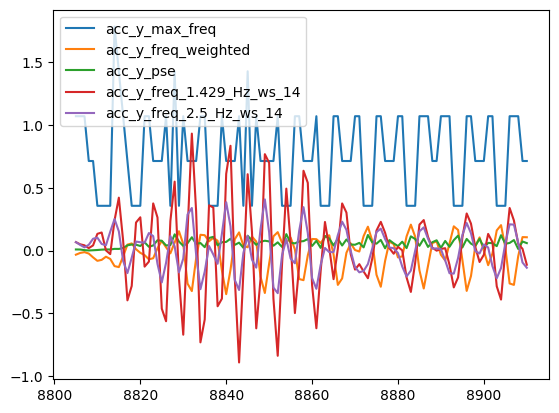

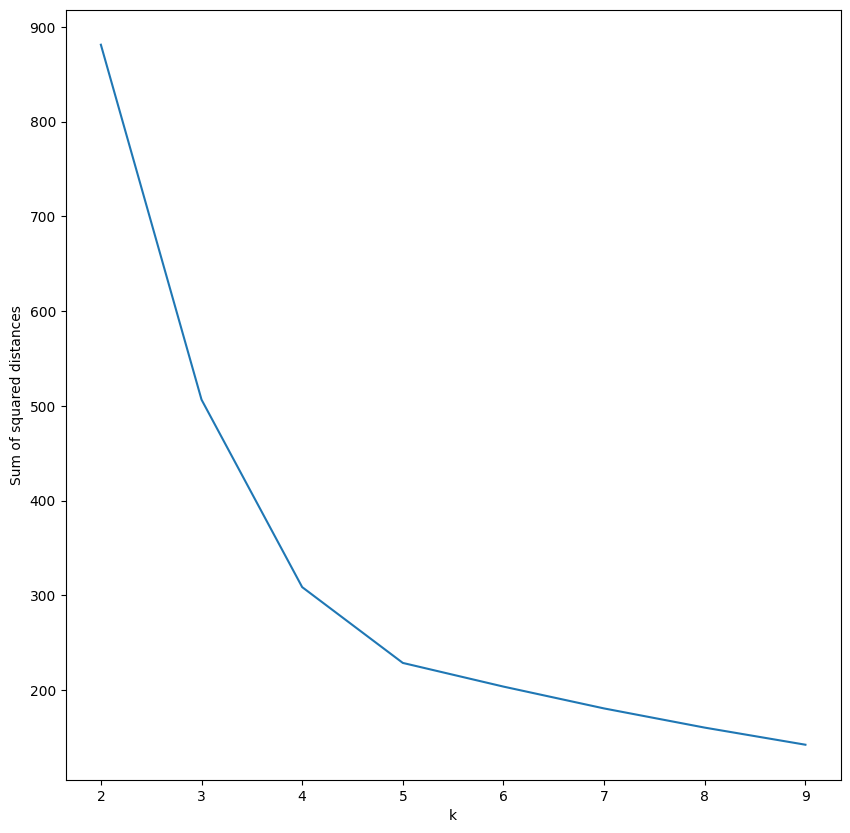

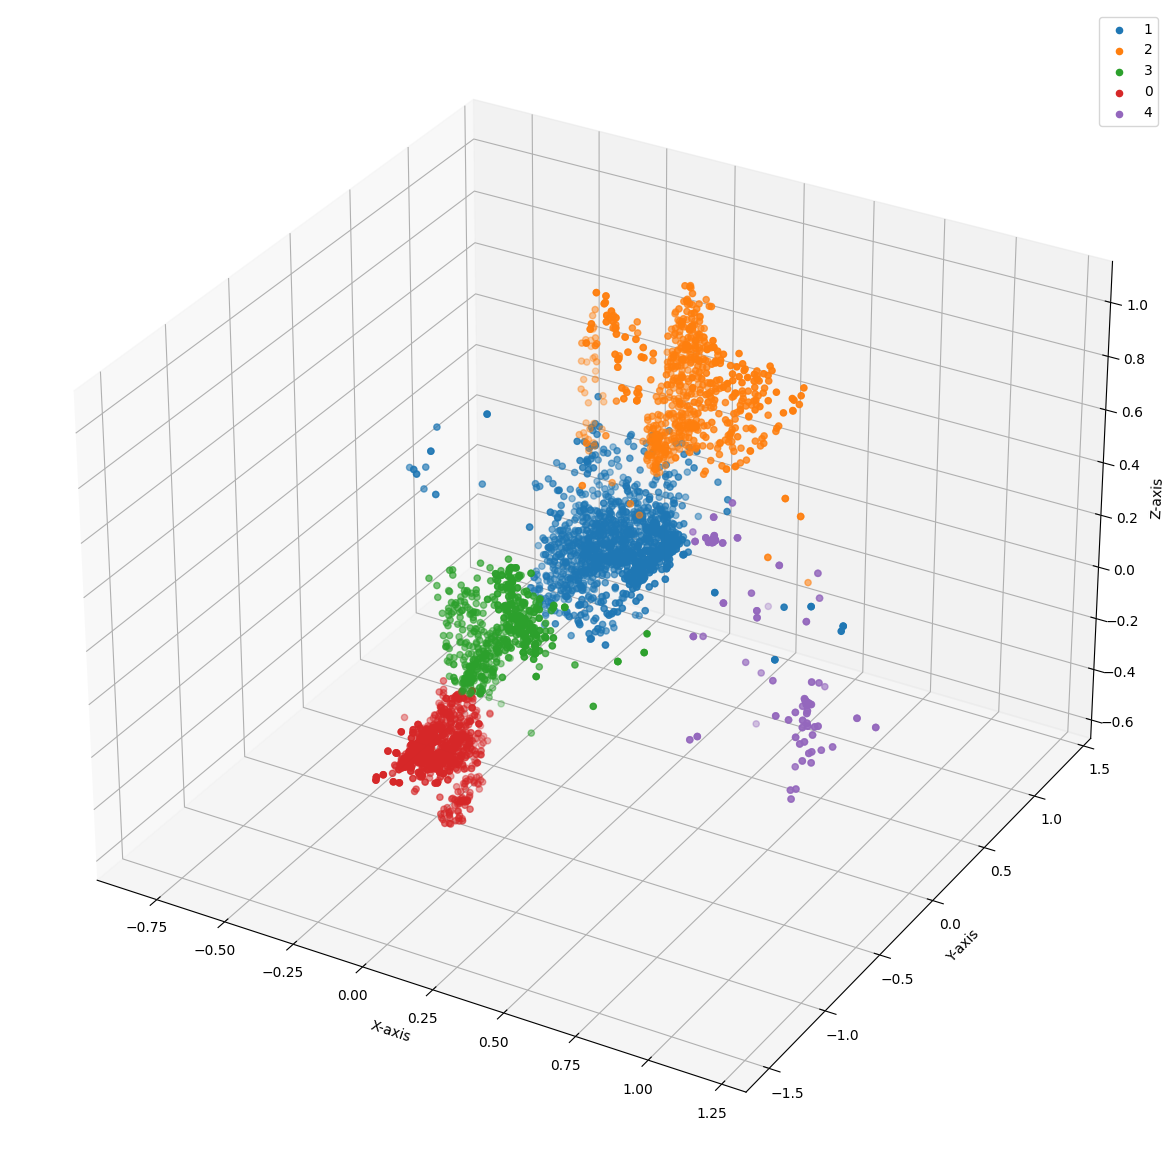

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from DataTransformation import LowPassFilter, PrincipalComponentAnalysis
from TemporalAbstraction import NumericalAbstraction
from sklearn.decomposition import PCA
from FrequencyAbstraction import FourierTransformation
from sklearn.cluster import KMeans
# --------------------------------------------------------------
# Load data
# --------------------------------------------------------------
df = pd.read_pickle("/Users/rishanthreddy/Desktop/Tracking barbell Exercises/data/interim/outliers_removed_chauvenets")


predictor_columns = list(df.columns[:6])
# --------------------------------------------------------------
# Dealing with missing values (imputation)
# --------------------------------------------------------------
df.info()
for col in predictor_columns:
    df[col] = df[col].interpolate()
    
df.info()
# --------------------------------------------------------------
# Calculating set duration
# --------------------------------------------------------------




for s in df["set"].unique():
    start = df[df["set"] == s].index[0]
    stop = df[df["set"] == s].index[-1]
    
    duration = stop - start
    df.loc[(df["set"] == s),"duration"] = duration.seconds
    
duration_df = df.groupby(["category"])["duration"].mean()


duration_df.iloc[0]/5
duration_df.iloc[1]/10

duration_df.head()
df.head(50)
    

# --------------------------------------------------------------
# Butterworth lowpass filter
# --------------------------------------------------------------
df_lowpass = df.copy()
LowPass = LowPassFilter()

fs = 1000/200
cutoff = 1.2

df_lowpass = LowPass.low_pass_filter(df_lowpass,"acc_y",fs,cutoff,order=5)

subset = df_lowpass[df_lowpass["set"] == 45]
print(subset["label"][0])


fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(20,10))
ax[0].plot(subset["acc_y"].reset_index(drop=True), label="raw data")
ax[1].plot(subset["acc_y_lowpass"].reset_index(drop=True), label="butterworth filter") 
ax[0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), fancybox=True, shadow=True)
ax[1].legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), fancybox=True, shadow=True)

for col in predictor_columns:
    df_lowpass = LowPass.low_pass_filter(df_lowpass, col, fs, cutoff, order=5)
    df_lowpass [col] = df_lowpass [col + "_lowpass"]
    del df_lowpass [col + "_lowpass"]
df_lowpass.head()
# --------------------------------------------------------------
# Principal component analysis PCA
# --------------------------------------------------------------
df_pca = df_lowpass.copy()

pca = PrincipalComponentAnalysis()
pc_values = pca.determine_pc_explained_variance(df_pca,predictor_columns)

plt.figure(figsize=(10, 10))
plt.plot(range(1, len(predictor_columns) + 1), pc_values)
plt.xlabel("principal component number")
plt.ylabel("explained variance")
plt.show()



df_pca = pca.apply_pca(df_pca,predictor_columns,3)
subset = df_pca[df_pca["set"] == 35]
subset[["pca_1","pca_2","pca_3"]].plot()

df_pca.head()

# --------------------------------------------------------------
# Sum of squares attributes
# --------------------------------------------------------------
df_squared = df_pca.copy()

acc_r = df_squared["acc_x"] ** 2 + df_squared["acc_y"] ** 2 + df_squared["acc_z"] ** 2 
gyr_r = df_squared["gyr_x"] ** 2 + df_squared ["gyr_y"] ** 2 + df_squared ["gyr_z"] **2

df_squared["acc_r"] = np.sqrt(acc_r)

df_squared["gyr_r"] = np.sqrt(gyr_r)

subset = df_squared[df_squared["set"] == 14]

subset[["acc_r", "gyr_r"]].plot(subplots=True)



# --------------------------------------------------------------
# Temporal abstraction
# --------------------------------------------------------------
df_temporal = df_squared.copy()

NumAbs = NumericalAbstraction()

predictor_columns = predictor_columns + ["acc_r", "gyr_r"]

ws = int(1000 / 200)

for col in predictor_columns:

    df_temporal = NumAbs.abstract_numerical(df_temporal, [col], ws, "mean")

    df_temporal = NumAbs.abstract_numerical(df_temporal, [col], ws, "std")

df_temporal_list = []

for s in df_temporal["set"].unique():

    subset = df_temporal[df_temporal["set"] == s].copy()

    for col in predictor_columns:
        subset = NumAbs.abstract_numerical(subset, [col], ws, "mean")
        subset = NumAbs.abstract_numerical(subset, [col], ws, "std")

    df_temporal_list.append(subset)

df_temporal = pd.concat(df_temporal_list)

subset[["acc_y", "acc_y_temp_mean_ws_5", "acc_y_temp_std_ws_5"]].plot()
subset[["gyr_y", "gyr_y_temp_mean_ws_5", "gyr_y_temp_std_ws_5"]].plot()


df_temporal.head()

# --------------------------------------------------------------
# Frequency features
# --------------------------------------------------------------
df_freq = df_temporal.copy().reset_index()
FreqAbs =  FourierTransformation()


fs = int(1000/200)
ws = int(2800/200)



df_freq = FreqAbs.abstract_frequency(df_freq, ["acc_y"], ws, fs)

#Visualize results

subset = df_freq[df_freq["set" ] == 15]

subset[["acc_y"]].plot()

df_freq.info()

subset[
[

"acc_y_max_freq",

"acc_y_freq_weighted",

"acc_y_pse",

"acc_y_freq_1.429_Hz_ws_14",

"acc_y_freq_2.5_Hz_ws_14",

]
].plot()


df_freq_list = []

for s in df_freq["set"].unique():

    print(f"Applying Fourier transformations to set {s}")

    subset = df_freq[df_freq["set"] == s].reset_index(drop=True).copy()

    subset = FreqAbs.abstract_frequency(subset, predictor_columns, ws, fs)

    df_freq_list.append(subset)

df_freq = pd.concat(df_freq_list).set_index("epoch (ms)", drop=True)

df_freq.info()

# --------------------------------------------------------------
# Dealing with overlapping windows
# --------------------------------------------------------------

df_freq = df_freq.dropna()
df_freq = df_freq.iloc[::2]

# --------------------------------------------------------------
# Clustering
# --------------------------------------------------------------
df_cluster = df_freq.copy()

cluster_columns = ["acc_x", "acc_y", "acc_z"]

k_values = range(2, 10)

inertias = []

for k in k_values:

    subset = df_cluster[cluster_columns]

    kmeans = KMeans(n_clusters=k, n_init=20, random_state=0)

    cluster_labels = kmeans.fit_predict(subset)

    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 10))

plt.plot(k_values, inertias)

plt.xlabel("k")
plt.ylabel("Sum of squared distances")
plt.show()

kmeans = KMeans(n_clusters=5, n_init=20, random_state=0)
subset = df_cluster[cluster_columns]
df_cluster["cluster"] = kmeans.fit_predict(subset)


fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection="3d")

for c in df_cluster["cluster"].unique():

    subset = df_cluster[df_cluster["cluster"] == c] 
    ax.scatter(subset["acc_x"], subset["acc_y"], subset["acc_z"],label=c)

ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

plt.legend()

plt.show()

# --------------------------------------------------------------
# Export dataset
# --------------------------------------------------------------
df_cluster.to_pickle("/Users/rishanthreddy/Desktop/Tracking barbell Exercises/data/interim/03_data_features.pkl")
